In [157]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
from torch_geometric.data import HeteroData
from torch import nn
import matplotlib.pyplot as plt

In [158]:

# 源节点特征 (6 个源节点，每个节点 16 维特征)
src = torch.tensor([
    [1, 1, 1, 1, 1, 1],  # 源节点索引
    [2, 2, 2, 2, 2, 2],
    [3, 3, 3, 3, 3, 3],
    [4, 4, 4, 4, 4, 4],  
    [5, 5, 5, 5, 5, 5]
], dtype=torch.float)
tgt = torch.tensor([
    [1, 1, 1, 1, 1, 1],  
    [1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1]
], dtype=torch.float)
adj = torch.tensor([
    [0, 3, 4, 1, 4, 1],  # 源节点索引
    [0, 0, 0, 1, 1, 2]   # 目标节点索引
], dtype=torch.long)
print("adj[0]:",adj[0])
data = HeteroData()
data['src'] = src
data['tgt'] = tgt
data['adj'] = adj


adj[0]: tensor([0, 3, 4, 1, 4, 1])


In [159]:
class GNN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GNN, self).__init__(aggr='sum', flow='source_to_target')
        self.linear = torch.nn.Linear(in_channels, out_channels)
        self.sigmoid = torch.nn.Sigmoid()
        self.matrix = nn.Parameter(torch.randn(in_channels, in_channels, requires_grad=True))

    def forward(self, data: HeteroData):
        x_src, x_tgt, edge_index = data['src'], data['tgt'], data['adj']
        out = self.propagate(x_src=x_src, x_tgt=x_tgt,edge_index=edge_index)
        #out = self.linear(out)
        return out
    
    def message(self, x_src,edge_index):
        message_src = x_src[edge_index[0]]
        return message_src
    
    def aggregate(self, inputs, edge_index, dim_size=None):
        weights = self.calculate_weights(edge_index[1])
        weights = weights.view(-1, 1).expand_as(inputs)
        inputs = inputs * weights

        return super().aggregate(inputs, edge_index[1])
    

    def update(self, aggr_out):
        aggr_out = torch.matmul(aggr_out, self.matrix.t())
        aggr_out = self.sigmoid(aggr_out)
        return aggr_out
    def calculate_weights(self,index):
        """
        计算每个索引位置的权重（根据相同元素的数量）
        Args:
            index: 索引数组，如 [0,0,0,1,1,2,2,3]
        Returns:
            weights: 权重数组，如 [0.33,0.33,0.33,0.5,0.5,0.5,0.5,1]
        """
        # 使用 unique_counts 获取每个元素的计数
        unique_elements, counts = torch.unique(index, return_counts=True)
        
        # 创建一个和输入相同大小的权重张量
        weights = torch.zeros_like(index, dtype=torch.float)
        
        # 为每个元素分配权重
        for element, count in zip(unique_elements, counts):
            weights[index == element] = 1.0 / count.float()
        
        return weights


In [160]:
def lossfunction(emd_out,data: HeteroData):
        x_src = data['src']
        edge_index = data['adj']
        x_src = x_src[edge_index[0]]
        x_src = x_src.t()
        simliarity = torch.matmul(emd_out , x_src)
        simliarity = torch.sum(simliarity, dim=0)
        loss = torch.mean(simliarity)
        return loss


In [161]:
model = GNN(6, 6)
out = model(data)
loss = lossfunction(out,data)
print("out:",out)
print("loss:",loss)



out: tensor([[1.0000, 0.9940, 0.0513, 0.9243, 0.9920, 0.8351],
        [1.0000, 0.9954, 0.0447, 0.9326, 0.9937, 0.8460],
        [0.9999, 0.9556, 0.1481, 0.8177, 0.9475, 0.7258]],
       grad_fn=<SigmoidBackward0>)
loss: tensor(44.9786, grad_fn=<MeanBackward0>)


In [162]:
iteration = 10000
learning_rate = 0.01
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for i in range(iteration):
    out = model(data)
    loss = lossfunction(out,data)
    loss_list.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print("loss:",loss)
print("out:",model(data))


loss: tensor(44.9786, grad_fn=<MeanBackward0>)
loss: tensor(0.3857, grad_fn=<MeanBackward0>)
loss: tensor(0.1815, grad_fn=<MeanBackward0>)
loss: tensor(0.1099, grad_fn=<MeanBackward0>)
loss: tensor(0.0750, grad_fn=<MeanBackward0>)
loss: tensor(0.0550, grad_fn=<MeanBackward0>)
loss: tensor(0.0423, grad_fn=<MeanBackward0>)
loss: tensor(0.0337, grad_fn=<MeanBackward0>)
loss: tensor(0.0276, grad_fn=<MeanBackward0>)
loss: tensor(0.0230, grad_fn=<MeanBackward0>)
loss: tensor(0.0195, grad_fn=<MeanBackward0>)
loss: tensor(0.0168, grad_fn=<MeanBackward0>)
loss: tensor(0.0146, grad_fn=<MeanBackward0>)
loss: tensor(0.0128, grad_fn=<MeanBackward0>)
loss: tensor(0.0113, grad_fn=<MeanBackward0>)
loss: tensor(0.0100, grad_fn=<MeanBackward0>)
loss: tensor(0.0090, grad_fn=<MeanBackward0>)
loss: tensor(0.0081, grad_fn=<MeanBackward0>)
loss: tensor(0.0073, grad_fn=<MeanBackward0>)
loss: tensor(0.0066, grad_fn=<MeanBackward0>)
loss: tensor(0.0060, grad_fn=<MeanBackward0>)
loss: tensor(0.0055, grad_fn=<Mea

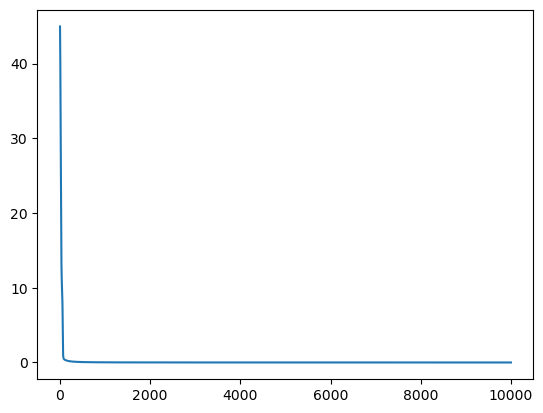

In [163]:

plt.plot(loss_list)
plt.show()


